# K-means Baseline (on Unclean Data) 


**Goal:** 
Use simple spectral features (delta, theta, gamma, HF power) from rodent HPC & PFC signals  
to see if **unsupervised clustering (K-means)** can separate known sleep states  
and **validate whether our preprocessing helps reveal meaningful structure**.

If clustering improves after basic downsampling or filtering,  
that suggests our preprocessing enhances biological signal quality.

so we need to : 
- Validate that the signals to see if it contain enough structure to separate sleep states.
- Use K-means as a **validation tool** for preprocessing quality:
   if clustering improves when data is cleaned,
   it means preprocessing is helping us.

## 1) Parameters

In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import welch, resample_poly
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Pretty plots
plt.style.use("seaborn-v0_8-whitegrid")

# --- Paths (edit these to your session) ---
HPC_PATH    = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/HPC_100_CH46.continuous.mat"
PFC_PATH    = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/PFC_100_CH11.continuous.mat"
STATES_MAT_PATH = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/post_trial1_2017-09-28_11-30-59-states.mat"  # labels @ 1 Hz

# --- Signal settings ---
FS_RAW   = 2500
FS_DS    = 500
EPOCH_S  = 2

# --- Bands ---
BANDS = {"delta": (0.5, 4), "theta": (6, 9), "gamma": (30, 80), "hf": (80, 200)}

# --- K sweep ---
K_RANGE = list(range(3, 11))  # try k=3..10
SEED = 42


In [2]:
def load_1d_from_mat(path):
    m = sio.loadmat(path)
    # pick the first non-dunder key that looks like a 1D or 2D (vector) array
    for k,v in m.items():
        if not k.startswith("__") and isinstance(v, np.ndarray):
            arr = np.squeeze(v)
            if arr.ndim == 1: return arr
            if arr.ndim == 2 and 1 in arr.shape: return np.ravel(arr)
    raise KeyError(f"No suitable 1D array in {path}. Keys: {list(m.keys())[:10]}")

HPC_raw = load_1d_from_mat(HPC_PATH)
PFC_raw = load_1d_from_mat(PFC_PATH)
print("Loaded:", HPC_raw.shape, PFC_raw.shape)

# Manual labels (1 Hz)
def load_states_1hz(path):
    m = sio.loadmat(path)
    cand = None
    for k,v in m.items():
        if isinstance(v, np.ndarray):
            arr = np.squeeze(v)
            if arr.ndim == 1 and arr.size > 10:
                cand = arr.astype(int); break
    return cand

STATES_1HZ = load_states_1hz(STATES_MAT_PATH)
print("States loaded:", None if STATES_1HZ is None else (STATES_1HZ.shape, np.unique(STATES_1HZ)))


Loaded: (6712704,) (6712704,)
States loaded: ((2684,), array([0, 1, 3, 4, 5]))


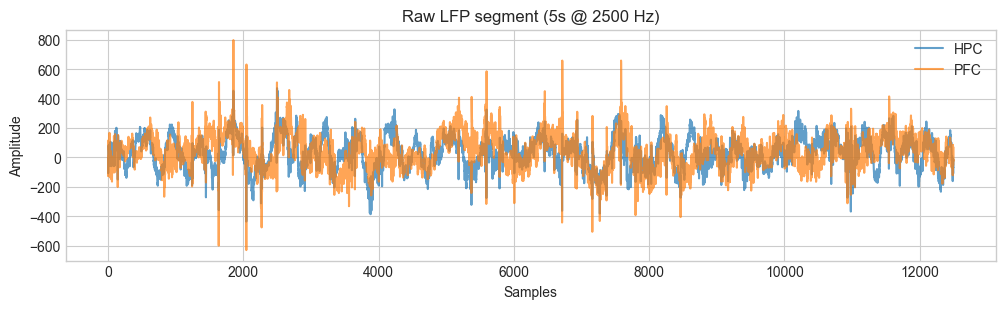

In [3]:
sec = 5
plt.figure(figsize=(12,3))
plt.plot(HPC_raw[:FS_RAW*sec], label="HPC", alpha=0.7)
plt.plot(PFC_raw[:FS_RAW*sec], label="PFC", alpha=0.7)
plt.title(f"Raw LFP segment ({sec}s @ {FS_RAW} Hz)")
plt.xlabel("Samples"); plt.ylabel("Amplitude"); plt.legend(); plt.show()


Downsampled: 1342541 Fs= 500


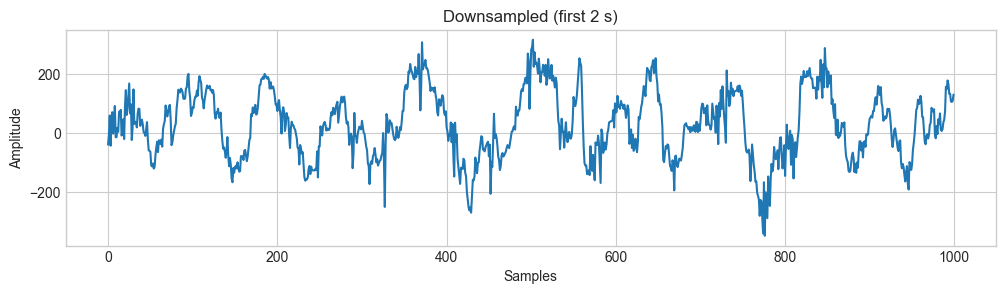

In [4]:
down = int(FS_RAW//FS_DS)  # expect 5
HPC = resample_poly(HPC_raw, up=1, down=down)
PFC = resample_poly(PFC_raw, up=1, down=down)
FS = FS_DS
print("Downsampled:", len(HPC), "Fs=", FS)

plt.figure(figsize=(12,2.8))
plt.plot(HPC[:FS*2], label="HPC @ 500 Hz")
plt.title("Downsampled (first 2 s)")
plt.xlabel("Samples"); plt.ylabel("Amplitude"); plt.show()


In [5]:
def make_epoch_indices(n_samples, fs, epoch_s):
    L = int(fs*epoch_s)
    nE = n_samples // L
    idx = np.arange(nE*L).reshape(nE, L)
    return idx, L, nE

def bandpower_epoch(x, fs, band, nperseg=512, noverlap=256):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap)
    m = (f>=band[0]) & (f<=band[1])
    if not np.any(m): return 0.0
    return float(np.trapz(Pxx[m], f[m]))

def extract_features(HPC, PFC, fs, epoch_s, bands):
    idx, L, nE = make_epoch_indices(len(HPC), fs, epoch_s)
    rows=[]
    for r in idx:
        h = HPC[r] - HPC[r].mean()
        p = PFC[r] - PFC[r].mean()
        delta = bandpower_epoch(p, fs, bands["delta"])
        theta = bandpower_epoch(h, fs, bands["theta"])
        gamma = bandpower_epoch(p, fs, bands["gamma"])
        hf    = bandpower_epoch(h, fs, bands["hf"]) + bandpower_epoch(p, fs, bands["hf"])
        tdr   = theta/(delta+1e-12)
        gdr   = gamma/(delta+1e-12)
        rows.append([delta, theta, gamma, tdr, gdr, hf])
    df = pd.DataFrame(rows, columns=["Delta_PFC","Theta_HPC","Gamma_PFC","Theta/Delta","Gamma/Delta","HF_80200"])
    return df, idx, L, nE

df_feats, epoch_idx, epoch_L, n_epochs = extract_features(HPC, PFC, FS, EPOCH_S, BANDS)
print("Epochs:", n_epochs)
display(df_feats.head())


C:\Users\lenovo\AppData\Local\Temp\ipykernel_31940\2830561437.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[m], f[m]))


Epochs: 1342


,Delta_PFC,Theta_HPC,Gamma_PFC,Theta/Delta,Gamma/Delta,HF_80200
0,5355.252156,579.927029,1307.544275,0.108291,0.244161,1555.839365
1,8171.462254,1249.665177,951.915042,0.152930,0.116493,1768.978470
2,3158.987405,4393.859284,1006.334279,1.390908,0.318562,1773.314560
3,50174.895955,3535.920109,1085.104617,0.070472,0.021626,1925.779550
4,7685.208592,1959.413076,1111.399194,0.254959,0.144615,1935.774507


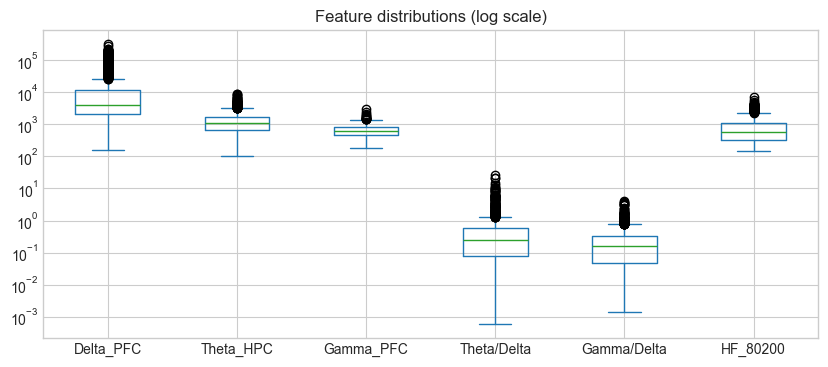

In [6]:
df_feats.plot(kind="box", figsize=(10,4), logy=True, title="Feature distributions (log scale)")
plt.show()


In [7]:
def map_states_to_epochs(epoch_idx, states_1hz, fs, epoch_s):
    if states_1hz is None: return None
    labs=[]
    for r in epoch_idx:
        start_s = int(r[0]//fs); end_s = int(r[-1]//fs)
        sec = np.arange(start_s, end_s+1)
        vals = states_1hz[sec]
        vals = vals[vals>0]
        labs.append(int(np.bincount(vals).argmax()) if vals.size else -1)
    return np.array(labs, dtype=int)

labels_epoch = map_states_to_epochs(epoch_idx, STATES_1HZ, FS, EPOCH_S)
print("Epoch labels:", None if labels_epoch is None else np.unique(labels_epoch))


Epoch labels: [-1  1  3  4  5]


In [8]:
# Prepare X (log1p on power-like columns, robust scale)
X = df_feats.copy()
X[["Delta_PFC","Theta_HPC","Gamma_PFC","HF_80200"]] = np.log1p(X[["Delta_PFC","Theta_HPC","Gamma_PFC","HF_80200"]])
Xs = RobustScaler().fit_transform(X.values)

sil_scores = {}
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    y = km.fit_predict(Xs)
    sil = silhouette_score(Xs, y)
    sil_scores[k] = sil
    print(f"k={k} → silhouette={sil:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
km = KMeans(n_clusters=best_k, n_init=20, random_state=SEED).fit(Xs)
clusters = km.labels_
print(f"\nChosen k = {best_k}")


k=3 → silhouette=0.768
k=4 → silhouette=0.334
k=5 → silhouette=0.317
k=6 → silhouette=0.320
k=7 → silhouette=0.273
k=8 → silhouette=0.268
k=9 → silhouette=0.269
k=10 → silhouette=0.273

Chosen k = 3


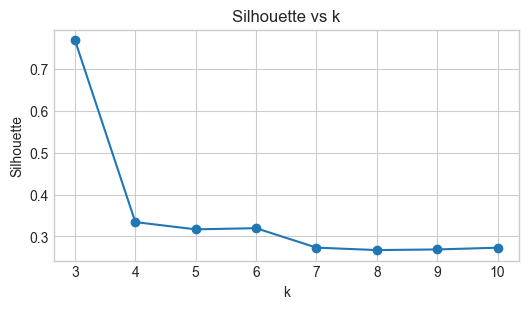

In [9]:
plt.figure(figsize=(6,3))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k")
plt.show()


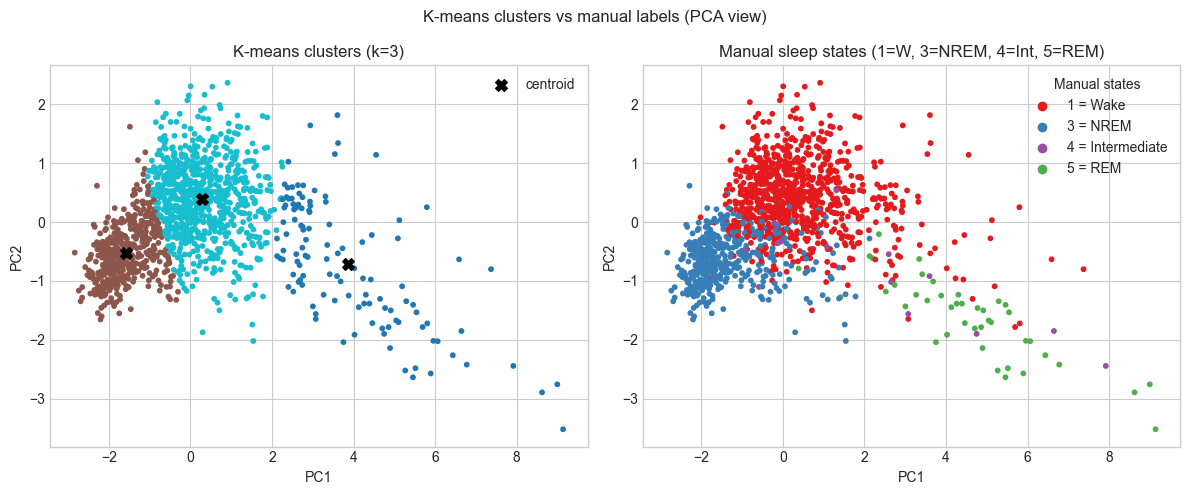

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import numpy as np

# ---- 1) Rebuild the exact feature matrix used for clustering ----
X_log = np.log1p(df_feats.values)
scaler = RobustScaler().fit(X_log)
X_scaled = scaler.transform(X_log)

# ---- 2) Fit KMeans here on the 6-D features (use your chosen k) ----
k = len(np.unique(clusters)) if 'clusters' in globals() else 3  # or best_k
km_vis = KMeans(n_clusters=k, n_init=20, random_state=42).fit(X_scaled)
clusters_vis = km_vis.labels_

# ---- 3) PCA only for visualization (2D projection of the 6-D space) ----
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centers_2d = pca.transform(km_vis.cluster_centers_)  # now shapes match (6 -> 2)

# ---- 4) Side-by-side plots ----
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_pca[:,0], X_pca[:,1], c=clusters_vis, cmap='tab10', s=10)
axs[0].scatter(centers_2d[:,0], centers_2d[:,1], c='black', s=70, marker='X', label='centroid')
axs[0].set_title(f"K-means clusters (k={k})")
axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")
axs[0].legend(loc='best')

if labels_epoch is not None:
    valid = labels_epoch != -1
    label_colors = {1:"#e41a1c", 3:"#377eb8", 4:"#984ea3", 5:"#4daf4a"}
    col_vec = [label_colors[int(v)] for v in labels_epoch[valid]]
    axs[1].scatter(X_pca[valid,0], X_pca[valid,1], c=col_vec, s=10)
    axs[1].set_title("Manual sleep states (1=W, 3=NREM, 4=Int, 5=REM)")
    axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")
    for code, name in [(1,"Wake"),(3,"NREM"),(4,"Intermediate"),(5,"REM")]:
        axs[1].scatter([], [], c=label_colors[code], label=f"{code} = {name}")
    axs[1].legend(loc='best', title="Manual states")

plt.suptitle("K-means clusters vs manual labels (PCA view)", fontsize=12)
plt.tight_layout()
plt.show()


###  Analysis

Even though the data wasn’t cleaned, it still holds biological structure (the algorithm could separate some sleep patterns). But since it only found 3 clusters instead of 4, this probably means noise, artefacts, or scale differences are still hiding finer distinctions. Once we apply proper preprocessing (filtering, artefact removal, EMG smoothing, normalization, etc.), the same K-means should give cleaner, more distinct clusters — proving our preprocessing improved the signal
